<a href="https://colab.research.google.com/github/jeremysb1/predictive-analytics/blob/main/facebook_prophet_problem.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Directory, Libraries, and Data

In [1]:
%cd /content/drive/MyDrive/Business Analyst Course/Predictive Analytics/Facebook Prophet

/content/drive/MyDrive/Business Analyst Course/Predictive Analytics/Facebook Prophet


In [18]:
#libraries
import numpy as np
import pandas as pd
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation
from fbprophet.utilities import regressor_coefficients

In [19]:
#load data
df = pd.read_csv("DHS_Daily_Report_2020.csv")
df.head()

,Date,Total Individuals in Shelter,Easter,Thanksgiving,Christmas,Temperature
0,1/1/2014,50689,0,0,0,2.17
1,1/2/2014,50797,0,0,0,2.51
2,1/3/2014,50954,0,0,0,-6.35
3,1/4/2014,50957,0,0,0,-1.27
4,1/5/2014,50957,0,0,0,7.18


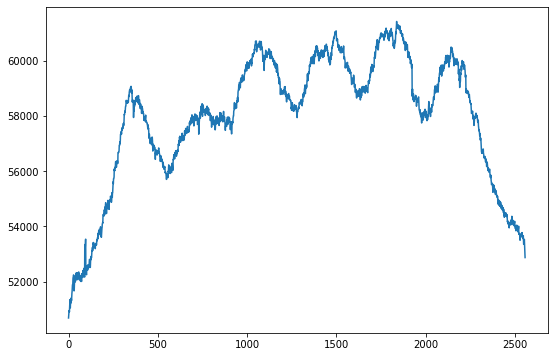

In [20]:
#plot
df['Total Individuals in Shelter'].plot(figsize = (9,6))

#Data Preparation

In [21]:
#date variable
df.Date = pd.to_datetime(df.Date, format = "%m/%d/%Y")
df.Date

0      2014-01-01
1      2014-01-02
2      2014-01-03
3      2014-01-04
4      2014-01-05
          ...    
2552   2020-12-27
2553   2020-12-28
2554   2020-12-29
2555   2020-12-30
2556   2020-12-31
Name: Date, Length: 2557, dtype: datetime64[ns]

In [22]:
#renaming variables
df = df.rename(columns = {'Date': 'ds',
                          'Total Individuals in Shelter': 'y'})

In [23]:
df.head(1)

,ds,y,Easter,Thanksgiving,Christmas,Temperature
0,2014-01-01,50689,0,0,0,2.17


#Holidays

In [24]:
#Easter
easter_dates = pd.to_datetime(df[df.Easter == 1].ds)
easter = pd.DataFrame({'holiday': 'easter',
                       'ds': easter_dates,
                       'lower_window': -5,
                       'upper_window': 2})
easter

,holiday,ds,lower_window,upper_window
109,easter,2014-04-20,-5,2
459,easter,2015-04-05,-5,2
816,easter,2016-03-27,-5,2
1201,easter,2017-04-16,-5,2
1551,easter,2018-04-01,-5,2
1936,easter,2019-04-21,-5,2
2293,easter,2020-04-12,-5,2


In [25]:
#Thanksgiving
thanksgiving_dates = pd.to_datetime(df[df.Thanksgiving == 1].ds)
thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
                             'ds': thanksgiving_dates,
                             'lower_window': -5,
                             'upper_window': 2})
thanksgiving

,holiday,ds,lower_window,upper_window
330,thanksgiving,2014-11-27,-5,2
694,thanksgiving,2015-11-26,-5,2
1058,thanksgiving,2016-11-24,-5,2
1422,thanksgiving,2017-11-23,-5,2
1786,thanksgiving,2018-11-22,-5,2
2157,thanksgiving,2019-11-28,-5,2
2521,thanksgiving,2020-11-26,-5,2


In [26]:
#combine events
holidays = pd.concat([easter, thanksgiving])
holidays

,holiday,ds,lower_window,upper_window
109,easter,2014-04-20,-5,2
459,easter,2015-04-05,-5,2
816,easter,2016-03-27,-5,2
1201,easter,2017-04-16,-5,2
1551,easter,2018-04-01,-5,2
1936,easter,2019-04-21,-5,2
2293,easter,2020-04-12,-5,2
330,thanksgiving,2014-11-27,-5,2
694,thanksgiving,2015-11-26,-5,2
1058,thanksgiving,2016-11-24,-5,2


In [27]:
#remove events from dataframe
df = df.drop(columns = ["Easter", "Thanksgiving"])
df.head()

,ds,y,Christmas,Temperature
0,2014-01-01,50689,0,2.17
1,2014-01-02,50797,0,2.51
2,2014-01-03,50954,0,-6.35
3,2014-01-04,50957,0,-1.27
4,2014-01-05,50957,0,7.18


#Facebook Prophet

In [28]:
#training and test split
test_days = 31
training_set = df.iloc[:-test_days, :]
test_set = df.iloc[-test_days:, :]
print(test_set.head(1))
print(training_set.tail(1))

             ds      y  Christmas  Temperature
2526 2020-12-01  53686          0        13.47
             ds      y  Christmas  Temperature
2525 2020-11-30  53745          0        16.62


In [29]:
#facebook prophet model
m = Prophet(growth= 'linear',
            yearly_seasonality = True,
            weekly_seasonality = True,
            daily_seasonality = False,
            holidays = holidays,
            seasonality_mode = "multiplicative",
            seasonality_prior_scale = 10,
            holidays_prior_scale = 10,
            changepoint_prior_scale = 0.05)
m.add_regressor('Christmas')
m.add_regressor('Temperature')
m.fit(training_set)

In [30]:
#coefficient regressor
regressor_coefficients(m)

,regressor,regressor_mode,center,coef_lower,coef,coef_upper
0,Christmas,multiplicative,0.000000,-0.000124,-0.000124,-0.000124
1,Temperature,multiplicative,14.960234,-0.000187,-0.000187,-0.000187


#Accuracy Assessment

In [32]:
#create future dataframe
future = m.make_future_dataframe(periods = test_days,
                          freq = 'D')
future = pd.concat([future, df.iloc[:,2:]],
                   axis = 1)
future.head(2)

,ds,Christmas,Temperature
0,2014-01-01,0,2.17
1,2014-01-02,0,2.51


In [33]:
#forecasting
forecast = m.predict(future)
forecast.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,Christmas,Christmas_lower,Christmas_upper,Temperature,...,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,additive_terms,additive_terms_lower,additive_terms_upper,yhat
0,2014-01-01,50062.269399,50467.824942,51238.971142,50062.269399,50062.269399,0.0,0.0,0.0,0.002392,...,0.000724,0.000724,0.000724,0.012646,0.012646,0.012646,0.0,0.0,0.0,50851.333820
1,2014-01-02,50083.268729,50459.781783,51247.575421,50083.268729,50083.268729,0.0,0.0,0.0,0.002329,...,0.000612,0.000612,0.000612,0.012814,0.012814,0.012814,0.0,0.0,0.0,50872.347029
2,2014-01-03,50104.268060,50538.936448,51320.171433,50104.268060,50104.268060,0.0,0.0,0.0,0.003986,...,-0.000839,-0.000839,-0.000839,0.013047,0.013047,0.013047,0.0,0.0,0.0,50915.606369
3,2014-01-04,50125.267391,50524.195508,51264.732366,50125.267391,50125.267391,0.0,0.0,0.0,0.003036,...,-0.001570,-0.001570,-0.001570,0.013341,0.013341,0.013341,0.0,0.0,0.0,50867.414581
4,2014-01-05,50146.266722,50532.704533,51302.816659,50146.266722,50146.266722,0.0,0.0,0.0,0.001455,...,0.000129,0.000129,0.000129,0.013693,0.013693,0.013693,0.0,0.0,0.0,50912.386026


In [34]:
#retrieve predictions
predictions = forecast.yhat[-test_days:]
predictions[:2]

2526    54930.998193
2527    55032.535237
Name: yhat, dtype: float64

In [35]:
#mae rmse
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(mean_absolute_error(test_set['y'], predictions))
print(np.sqrt(mean_squared_error(test_set['y'], predictions)))

1321.554527842594
1327.9982599857976


#Vizualization

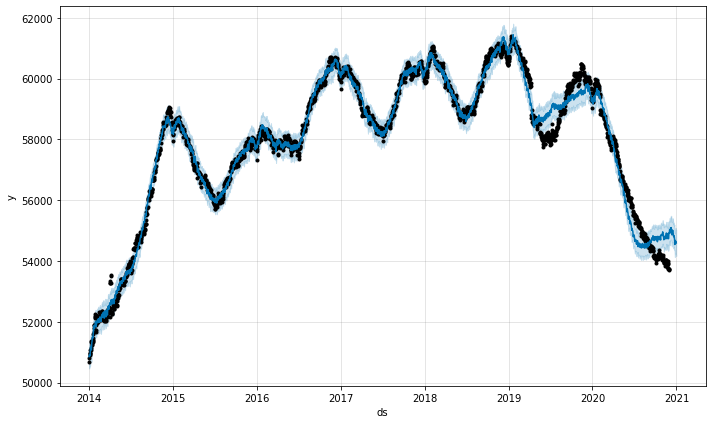

In [36]:
#forecast
m.plot(forecast);

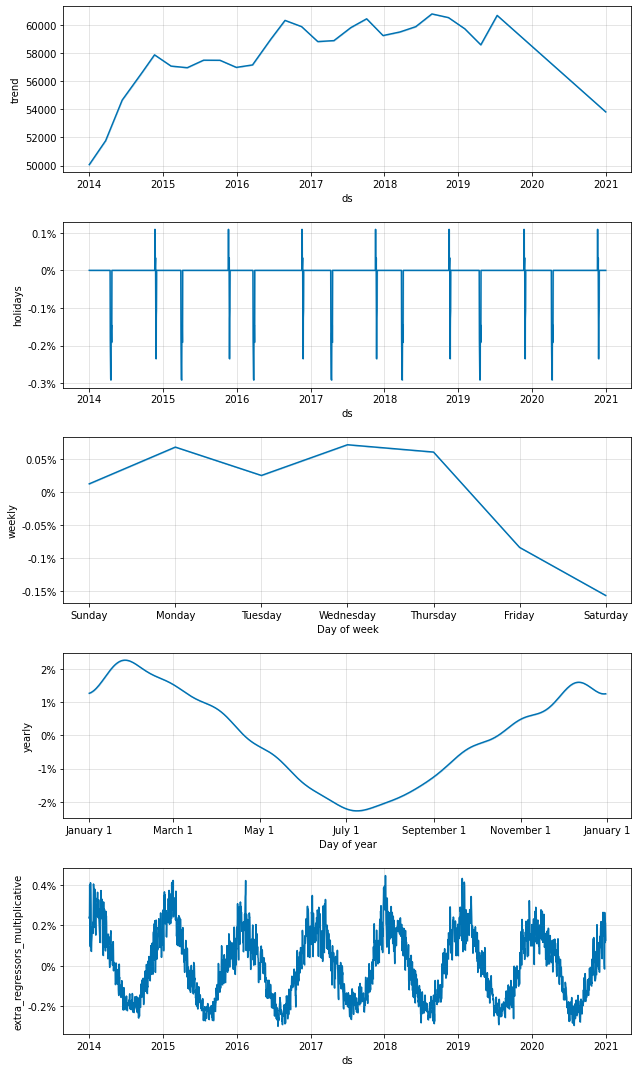

In [37]:
#plot components
m.plot_components(forecast);

#Parameter Tuning

In [38]:
#grid
from sklearn.model_selection import ParameterGrid
param_grid = {'seasonality_prior_scale': [5, 10, 20],
              'holidays_prior_scale': [5, 10, 20],
              'changepoint_prior_scale': [0.01, 0.05, 0.1]}
grid = ParameterGrid(param_grid)

In [ ]:
#hyperparameter
rmse = []

#parameter tuning loop
for params in grid:
  m = Prophet(growth = 'linear',
              yearly_seasonality = True,
              weekly_seasonality = True,
              daily_seasonality = False,
              seasonality_mode = 'multiplicative',
              seasonality_prior_scale = params['seasonality_prior_scale'],
              holidays_prior_scale = params['holidays_prior_scale'],
              changepoint_prior_scale = params['changepoint_prior_scale'])
  m.add_regressor('Christmas')
  m.fit(training_set)

  df_cv = cross_validation(model = m,
                           horizon = '31 days',
                           initial = '2300 days',
                           parallel = "processes")
  
  error = np.sqrt(mean_squared_error(df_cv['y'], df_cv['yhat']))

  rmse.append(error)


In [40]:
#Fetch the best parameters
best_params = grid[np.argmin(rmse)]
print(best_params)

{'seasonality_prior_scale': 10, 'holidays_prior_scale': 5, 'changepoint_prior_scale': 0.1}
